<a href="https://colab.research.google.com/github/Henil21/Natural_Language_processing/blob/main/LSTM_BI_GRU_Hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/NLP/Offensive.csv')

In [ ]:
# data=pd.read_csv('/content/en_dataset_with_stop_words.csv')
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
train_sentences,val_sentences,train_labels,val_labels=train_test_split(data["tweet"].to_numpy(),
                                                                       data["class"].to_numpy(),
                                                                       test_size=0.3,
                                                                       random_state=42)
print(train_sentences[2])
print(train_labels[2])

I be telling Mcgirt music ain't enough.You gotta have a non music related agenda.Them crackers want to sell something with your face.
1


In [ ]:
# len(train_sentences)
data["class"].unique()

#class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

array([2, 1, 0])

In [ ]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

14

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length = 1000 # max number of words to have in our vocabulary
max_length = 20 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    standardize="lower_and_strip_punctuation",
                                     split="whitespace",
                                    output_mode="int",
                                    output_sequence_length=max_length)
text_vectorizer.adapt(train_sentences)


In [ ]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,#set the input shape
                             output_dim=128,
                             input_length=max_length)

In [ ]:
# Convert text into number
from sklearn.feature_extraction.text import TfidfVectorizer
# our model
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

# create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),# convert words to number using tfidf
    ("clf",MultinomialNB())# model the text
])
# fit the pipleine to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score=model_0.score(val_sentences,val_labels)
# as we use .evaluate in tf for sklearn its .score
baseline_score*100

78.5743106926698

In [ ]:
# import tensorflow_hub as hub
# embed=hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
# sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
#                                                                     input_shape=(),
#                                                                     dtype=tf.string,
#                                                                     trainable=False,
#                                                                     name="USE"
#                                                                     )

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras.optimizers import RMSprop

input=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(input)
x=embedding(x)
x=layers.LSTM(64,return_sequences=True)(x)

x=layers.Bidirectional(layers.GRU(64))(x)
x=layers.Dropout(0.5)(x)


outputs=layers.Dense(3,activation='softmax')(x)
model_4=tf.keras.Model(input,outputs,name="model_4_bidirectional")

In [ ]:
# Compile model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_4_history=model_4.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels))

Epoch 1/5
543/543 [==============================] - 36s 42ms/step - loss: 0.4250 - accuracy: 0.8501 - val_loss: 0.3385 - val_accuracy: 0.8748
Epoch 2/5
543/543 [==============================] - 8s 14ms/step - loss: 0.2970 - accuracy: 0.8903 - val_loss: 0.3125 - val_accuracy: 0.8803
Epoch 3/5
543/543 [==============================] - 6s 12ms/step - loss: 0.2723 - accuracy: 0.9000 - val_loss: 0.3332 - val_accuracy: 0.8749
Epoch 4/5
543/543 [==============================] - 7s 13ms/step - loss: 0.2567 - accuracy: 0.9048 - val_loss: 0.3236 - val_accuracy: 0.8779
Epoch 5/5
543/543 [==============================] - 6s 11ms/step - loss: 0.2415 - accuracy: 0.9089 - val_loss: 0.3372 - val_accuracy: 0.8751


In [ ]:

import pandas as pd
def plot_loss_curves(hist):
    pd.DataFrame(hist.history).plot(figsize=(5,5))

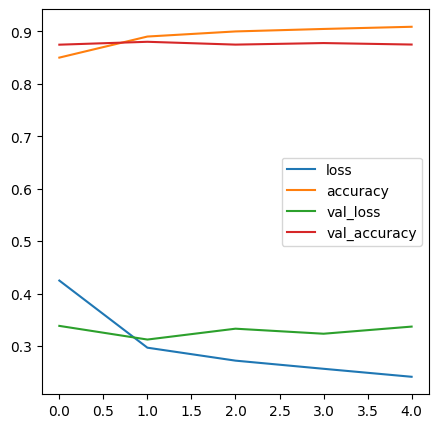

In [ ]:
plot_loss_curves(model_4_history)

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  # Calculate model accuracy
  model_accuracy=accuracy_score(y_true,y_pred)*100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision":model_precision*100,
                   "recall":model_recall*100,
                   "f1":model_f1*100
                   }
  return model_results

In [ ]:
y_pred=model_4.predict(val_sentences)
y_pred[:10]

233/233 [==============================] - 2s 4ms/step


array([[6.33392250e-03, 9.93576944e-01, 8.91851960e-05],
       [1.82672925e-02, 9.81623650e-01, 1.09117915e-04],
       [3.69391106e-02, 4.62652713e-01, 5.00408173e-01],
       [2.18975902e-01, 7.79841006e-01, 1.18306791e-03],
       [6.51514605e-02, 9.34724867e-01, 1.23646591e-04],
       [6.54219510e-03, 4.63528931e-01, 5.29928923e-01],
       [9.36129596e-03, 9.90540802e-01, 9.78841854e-05],
       [7.48656923e-03, 9.92218018e-01, 2.95498670e-04],
       [3.14280903e-03, 9.96675134e-01, 1.82045856e-04],
       [8.84301378e-04, 9.99060571e-01, 5.51348021e-05]], dtype=float32)

In [ ]:
predicted_class_indices = np.argmax(y_pred, axis=1)
print(predicted_class_indices[:20])
print(val_labels[:20])

[1 1 2 1 1 2 1 1 1 1 1 2 1 0 1 1 2 1 1 2]
[1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 2]


In [ ]:
calculate_results(val_labels,predicted_class_indices)

{'accuracy': 87.50504371217215,
 'precision': 86.49043915483223,
 'recall': 87.50504371217215,
 'f1': 86.51169011066686}